In [ ]:
import io

import numpy as np
import pandas as pd

import keras

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [33]:
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBRegressor

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [35]:
dataset_EmisionLines = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/EmissionLines.csv")
dataset_DiagnRatios = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/DiagnRatios.csv")
dataset_rion_rout = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/rion_rout.csv")
dataset_OutPar = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/OutPar.csv")

In [36]:
merged_df_EmDiag = pd.merge(dataset_EmisionLines, dataset_DiagnRatios, on='id', how='inner')  # Inner join

In [37]:
num_rows_without_na = dataset_EmisionLines.dropna().shape
print(num_rows_without_na)

(0, 25)


In [38]:
dataset_rion_rout['rion'] = np.log1p(dataset_rion_rout['rion'])
dataset_rion_rout['rout'] = np.log1p(dataset_rion_rout['rout'])

merged_features =  pd.merge(dataset_EmisionLines, dataset_DiagnRatios, on='id', how='inner')
merged_features =  pd.merge(merged_features, dataset_rion_rout, on='id', how='inner')

In [ ]:
df_target = dataset_OutPar.drop('element_nitr_abund', axis=1)
df_target = df_target.dropna()
print(df_target.shape)
print(df_target.isna().sum())

df_target_2 = dataset_OutPar[['id', 'element_nitr_abund']]
df_target_2 = df_target_2.dropna()

(188515, 17)
id                    0
dilc                  0
radius                0
qh                    0
hden                  0
hpow                  0
fpow                  0
srdv                  0
sigm                  0
filling_factor        0
element_heli_abund    0
element_oxyg_abund    0
element_neon_abund    0
element_sulp_abund    0
element_argo_abund    0
element_iron_abund    0
grain_abund           0
dtype: int64


In [40]:
print(dataset_rion_rout.shape)
new_ion_rout_par = dataset_rion_rout.dropna()
print(new_ion_rout_par.shape)

(653329, 3)
(0, 3)


In [ ]:
input_to_model = pd.merge(merged_features, df_target, on='id', how='inner')

X = input_to_model.iloc[:, 1:merged_features.shape[1]]
y = input_to_model.iloc[:, merged_features.shape[1]:merged_features.shape[1]+df_target.shape[1]-1]
print(y.shape)

# 80%-20% split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(188515, 16)


In [43]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [44]:
params = {
    'objective': 'reg:squarederror',  # 'binary:logistic' for classification
    'eval_metric': 'rmse',  # Use 'logloss' for classification
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    'subsample': 0.8,  # Helps prevent overfitting
    'colsample_bytree': 0.8,  # Helps prevent overfitting
}

In [45]:
xgb_model = XGBRegressor(**params)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
y_pred = xgb_model.predict(X_test)

In [ ]:
#model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
nrmse = rmse / (np.max(y_test) - np.min(y_test))

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Normalized RMSE: {nrmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.16
Normalized RMSE: 0.0025
Mean Absolute Error (MAE): 0.03
R² Score: 0.86


In [48]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

print(y_test.shape)
print(y_pred.shape)

(37703, 16)
(37703, 16)


In [50]:
num_outputs = y_test.shape[1]

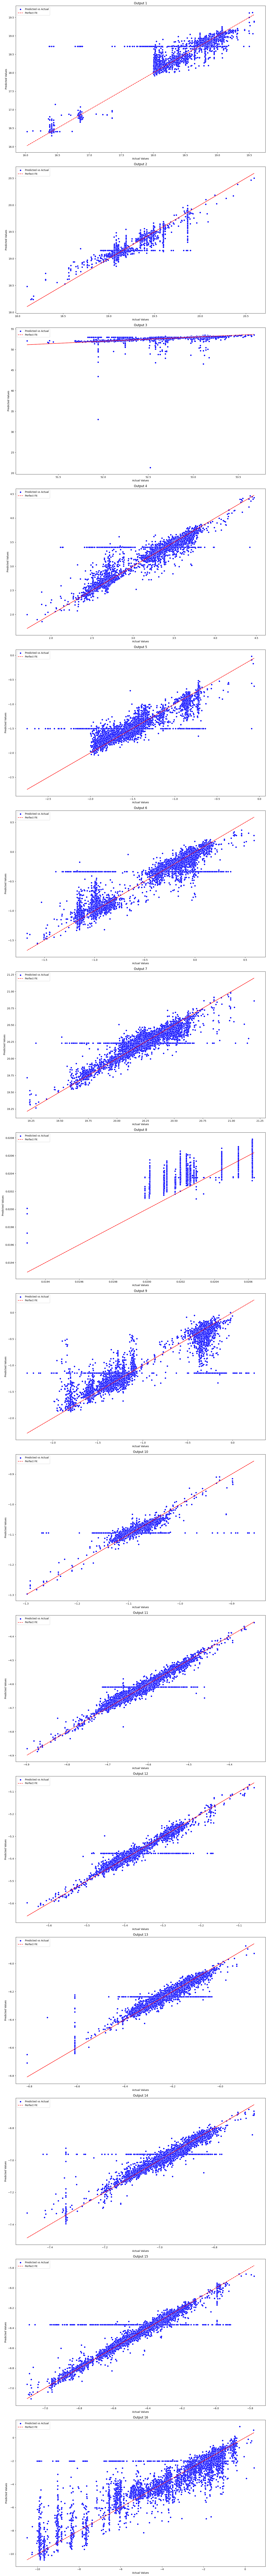

In [57]:
fig, axes = plt.subplots(num_outputs, 1, figsize=(15, 9*num_outputs))

for i in range(num_outputs):
    ax = axes[i] if num_outputs > 1 else axes
    sns.scatterplot(x=y_test[:, i], y=y_pred[:, i], color='blue', label="Predicted vs Actual", ax=ax)
    ax.plot(y_test[:, i], y_test[:, i], color='red', linestyle='dashed', label="Perfect Fit")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"Output {i+1}")
    ax.legend()

plt.tight_layout()
plt.show()

In [53]:
print(dataset_OutPar.info)

<bound method DataFrame.info of             id       dilc     radius         qh      hden      hpow      fpow  \
0            1        NaN        NaN        NaN       NaN       NaN       NaN   
1            2        NaN  18.180525  52.156895  2.458671 -1.265370       NaN   
2            3        NaN  20.180525  52.156895  2.458671 -1.265370       NaN   
3            4        NaN  19.180525  52.156895  2.458671 -1.265370       NaN   
4            5        NaN  19.180525  52.156895  2.458671 -1.265370       NaN   
...        ...        ...        ...        ...       ...       ...       ...   
653324  653325  18.317142  19.189104  52.965908  3.570145 -1.262076 -0.131844   
653325  653326  18.317142  19.189104  52.965908  3.570145 -1.262076 -0.131844   
653326  653327  18.328102  19.189104  52.965908  3.569968 -1.261785 -0.131646   
653327  653328  18.328102  19.189104  52.965908  3.569968 -1.261785 -0.131646   
653328  653329  18.328102  19.189104  52.965908  3.569968 -1.261785 -0.131646

In [54]:
for col in dataset_OutPar.columns:
    print(f"Column '{col}' has {dataset_OutPar[col].isna().sum()} missing values")

Column 'id' has 0 missing values
Column 'dilc' has 68209 missing values
Column 'radius' has 38765 missing values
Column 'qh' has 44760 missing values
Column 'hden' has 36466 missing values
Column 'hpow' has 39106 missing values
Column 'fpow' has 278330 missing values
Column 'srdv' has 297084 missing values
Column 'sigm' has 297084 missing values
Column 'filling_factor' has 36552 missing values
Column 'element_heli_abund' has 38406 missing values
Column 'element_oxyg_abund' has 272974 missing values
Column 'element_nitr_abund' has 599198 missing values
Column 'element_neon_abund' has 374934 missing values
Column 'element_sulp_abund' has 367234 missing values
Column 'element_argo_abund' has 374934 missing values
Column 'element_iron_abund' has 374934 missing values
Column 'grain_abund' has 97283 missing values
